<a href="https://colab.research.google.com/github/mbjallow6/Machine-learning-with-python-fhd/blob/main/momodou_jallow_721667_HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pdfdocument

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 115.0 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [ ]:
import requests
import pandas as pd
import numpy as np 
import datetime
from tabulate import tabulate
from pdfdocument.document import PDFDocument
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image, PageBreak
from reportlab.lib.units import inch
import zipfile
from lxml import etree
from lxml.builder import E
import io
import json
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, SubElement, Comment, tostring
from xml.dom import minidom
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files
uploaded = files.upload()
zip_file_name = list(uploaded.keys())[0]

Saving f1db_csv.zip to f1db_csv.zip


In [ ]:
def load_and_extract_csv_files(zip_file_name):
    data_frames = {}

    with zipfile.ZipFile(zip_file_name, 'r') as z:
        for file in z.namelist():
            if file.endswith('.csv'):
                with z.open(file) as f:
                    content = io.TextIOWrapper(f)
                    df_name = 'df_' + file[:-4].replace(' ', '_')
                    data_frames[df_name] = pd.read_csv(content)

    return data_frames

In [ ]:
def save_column_names(data_frames, txt_file_name):
    columns_info = []

    for file_name, df in data_frames.items():
        columns_info.append({'file_name': file_name, 'columns': ', '.join(df.columns)})

    columns_df = pd.DataFrame(columns_info)
    columns_df.to_csv(txt_file_name, index=False, sep='\t')

In [ ]:
data_frames = load_and_extract_csv_files("f1db_csv.zip")
save_col_names = save_column_names(load_and_extract_csv_files("f1db_csv.zip"),"colnames.txt")
df_circuits = data_frames['df_circuits']
df_constructor_results = data_frames['df_constructor_results']
df_constructors = data_frames['df_constructors']
df_drivers = data_frames['df_drivers']
df_driver_standings = data_frames['df_driver_standings']
df_qualifying = data_frames['df_qualifying']
df_results = data_frames['df_results']
df_races = data_frames['df_races']
df_circuits = data_frames['df_circuits']
df_lap_times = data_frames['df_lap_times']
df_pit_stops = data_frames['df_pit_stops']

In [ ]:
def prettify_xml(elem):
    rough_string = etree.tostring(elem, encoding="utf-8")
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def merge_related_dataframes_and_export(data_frames):
    # Merge related dataframes
    races_and_circuits = pd.merge(data_frames["df_races"], data_frames["df_circuits"], on="circuitId")
    results_and_drivers = pd.merge(data_frames["df_results"], data_frames["df_drivers"], on="driverId")
    results_and_constructors = pd.merge(results_and_drivers, data_frames["df_constructors"], on="constructorId", suffixes=("_driver", "_constructor"))
    merged_df = pd.merge(races_and_circuits, results_and_constructors, on="raceId")
    
    # Create pivot table for driver standings
    driver_standings_pivot = data_frames["df_driver_standings"].pivot_table(index=["raceId", "driverId"], values=["points", "position"], aggfunc="sum").reset_index()

    # Merge driver standings pivot table with the main merged dataframe
    merged_df = pd.merge(merged_df, driver_standings_pivot, on=["raceId", "driverId"], suffixes=("", "_driver_standings"))

    # Export combined data to JSON
    merged_df.to_json("/content/drive/MyDrive/combined_data.json", orient="records", date_format="iso")

    # Export combined data to XML
    with open("/content/drive/MyDrive/combined_data.xml", "w", encoding="utf-8") as xml_file:
        xml_root = etree.Element("data")
        
        for index, row in merged_df.iterrows():
            row_element = etree.SubElement(xml_root, "row")
            
            for column_name, cell_value in row.items():
                cell_element = etree.SubElement(row_element, column_name)
                
                if pd.isna(cell_value):
                    cell_element.text = ""
                else:
                    cell_element.text = str(cell_value)

        # Write prettified XML to file
        xml_file.write(prettify_xml(xml_root))

# Call the function with your data_frames dictionary
merge_related_dataframes_and_export(data_frames)


In [ ]:
def concatenate_dataframes(data_frames):
    combined_df = pd.DataFrame()

    for df_name, df in data_frames.items():
        df['source_file'] = df_name
        combined_df = combined_df.append(df, ignore_index=True)

    return combined_df

In [ ]:
def calculate_descriptive_statistics(data_frames, output_file='/content/drive/MyDrive/HW1/descriptive_statistics.md'):
    # Calculate the descriptive statistics
    lap_times = data_frames['df_lap_times']['milliseconds']
    pit_stop_durations = data_frames['df_pit_stops']['milliseconds']
    points_scored = data_frames['df_results']['points']

    statistics = [
        ['Lap times (milliseconds)', lap_times.mean(), lap_times.median(), lap_times.std(), lap_times.max() - lap_times.min()],
        ['Pit stop durations (milliseconds)', pit_stop_durations.mean(), pit_stop_durations.median(), pit_stop_durations.std(), pit_stop_durations.max() - pit_stop_durations.min()],
        ['Points scored', points_scored.mean(), points_scored.median(), points_scored.std(), points_scored.max() - points_scored.min()]
    ]

    # Save the results as a Markdown file
    headers = ['Feature', 'Mean', 'Median', 'Standard Deviation', 'Range']
    table = tabulate(statistics, headers=headers, tablefmt='pipe')

    with open(output_file, 'w') as f:
        f.write(table)

calculate_descriptive_statistics(data_frames)
    

In [ ]:
def calculate_descriptive_statistics_pdf(data_frames, output_file='/content/drive/MyDrive/HW1/descriptive_statistics.pdf'):
    # Calculate the descriptive statistics
    lap_times = data_frames['df_lap_times']['milliseconds']
    pit_stop_durations = data_frames['df_pit_stops']['milliseconds']
    points_scored = data_frames['df_results']['points']

    statistics = [
        ['Lap times (milliseconds)', lap_times.mean(), lap_times.median(), lap_times.std(), lap_times.max() - lap_times.min()],
        ['Pit stop durations (milliseconds)', pit_stop_durations.mean(), pit_stop_durations.median(), pit_stop_durations.std(), pit_stop_durations.max() - pit_stop_durations.min()],
        ['Points scored', points_scored.mean(), points_scored.median(), points_scored.std(), points_scored.max() - points_scored.min()]
    ]

    # Save the results as a PDF file
    headers = ['Feature', 'Mean', 'Median', 'Standard Deviation', 'Range']
    table = tabulate(statistics, headers=headers, tablefmt='pipe')

    pdf = PDFDocument(output_file)
    pdf.init_report()
    pdf.h2("Descriptive Statistics")
    pdf.p(table)
    pdf.generate()

calculate_descriptive_statistics_pdf(data_frames)

In [ ]:
def analyze_circuit_distribution(df_circuits, output_filename):
    # Group circuits by country and count them
    circuit_country_counts = df_circuits['country'].value_counts()
    
    # Create a bar chart
    fig, ax = plt.subplots()
    ax.bar(circuit_country_counts.index, circuit_country_counts.values)
    ax.set_title('Number of Circuits per Country')
    ax.set_xlabel('Country')
    ax.set_ylabel('Number of Circuits')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Save the bar chart as an image file
    plt.savefig('temp_circuit_chart.png', bbox_inches='tight')
    plt.close()

    # Save the bar chart as a PDF
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    story = []

    circuit_chart = Image('temp_circuit_chart.png', width=6.5 * inch, height=4 * inch)
    story.append(circuit_chart)

    doc.build(story)

analyze_circuit_distribution(df_circuits, '/content/drive/MyDrive/HW1/circuit_distribution.pdf')

In [ ]:
def analyze_constructor_points(df_constructor_results, df_constructors, output_filename, top_n=10):
    # Calculate the total points for each constructor
    constructor_points = df_constructor_results.groupby('constructorId')['points'].sum()
    
    # Merge the constructor points with the constructor names
    constructor_points = constructor_points.reset_index().merge(df_constructors[['constructorId', 'name']], on='constructorId')
    
    # Sort the constructors by total points and select the top N constructors
    constructor_points = constructor_points.sort_values(by='points', ascending=False).head(top_n)
    
    # Create a horizontal bar chart
    fig, ax = plt.subplots()
    ax.barh(constructor_points['name'], constructor_points['points'])
    ax.set_title(f'Total Points Earned by Top {top_n} Constructors')
    ax.set_xlabel('Points')
    ax.set_ylabel('Constructor')
    plt.tight_layout()

    # Save the bar chart as an image file
    plt.savefig('temp_constructor_points_chart.png', bbox_inches='tight')
    plt.close()

    # Save the bar chart as a PDF
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    story = []

    constructor_points_chart = Image('temp_constructor_points_chart.png', width=6.5 * inch, height=4 * inch)
    story.append(constructor_points_chart)

    doc.build(story)


analyze_constructor_points(df_constructor_results, df_constructors, '/content/drive/MyDrive/HW1/constructor_points.pdf')


In [ ]:
def analyze_constructor_nationality(df_constructors, df_constructor_results, output_filename, top_n=10):
    # Calculate the number of constructors per nationality
    constructor_nationality_count = df_constructors['nationality'].value_counts().reset_index()
    constructor_nationality_count.columns = ['nationality', 'count']
    
    # Calculate the total points earned by constructors of each nationality
    constructor_points = df_constructor_results.groupby('constructorId')['points'].sum().reset_index()
    constructor_points = constructor_points.merge(df_constructors[['constructorId', 'nationality']], on='constructorId')
    constructor_points_sum = constructor_points.groupby('nationality')['points'].sum().reset_index()
    
    # Merge the number of constructors and the total points by nationality
    constructor_nationality_stats = constructor_nationality_count.merge(constructor_points_sum, on='nationality')
    constructor_nationality_stats = constructor_nationality_stats.sort_values(by='points', ascending=False).head(top_n)
    
    # Create a horizontal bar chart for the number of constructors by nationality
    fig, ax = plt.subplots()
    ax.barh(constructor_nationality_stats['nationality'], constructor_nationality_stats['count'])
    ax.set_title(f'Number of Constructors by Nationality (Top {top_n})')
    ax.set_xlabel('Number of Constructors')
    ax.set_ylabel('Nationality')
    plt.tight_layout()

    # Save the bar chart as an image file
    plt.savefig('temp_constructor_nationality_count_chart.png', bbox_inches='tight')
    plt.close()

    # Create a horizontal bar chart for the total points earned by constructors of each nationality
    fig, ax = plt.subplots()
    ax.barh(constructor_nationality_stats['nationality'], constructor_nationality_stats['points'])
    ax.set_title(f'Total Points Earned by Constructors by Nationality (Top {top_n})')
    ax.set_xlabel('Points')
    ax.set_ylabel('Nationality')
    plt.tight_layout()

    # Save the bar chart as an image file
    plt.savefig('temp_constructor_nationality_points_chart.png', bbox_inches='tight')
    plt.close()

    # Save the bar charts as a PDF
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    story = []

    constructor_nationality_count_chart = Image('temp_constructor_nationality_count_chart.png', width=6.5 * inch, height=4 * inch)
    story.append(constructor_nationality_count_chart)
    story.append(PageBreak())

    constructor_nationality_points_chart = Image('temp_constructor_nationality_points_chart.png', width=6.5 * inch, height=4 * inch)
    story.append(constructor_nationality_points_chart)

    doc.build(story)
analyze_constructor_nationality(df_constructors, df_constructor_results, '/content/drive/MyDrive/HW1/constructor_nationality.pdf', top_n=10)


In [ ]:
def analyze_driver_demographics(df_drivers, df_driver_standings, output_filename, top_n=10):
    # Calculate driver age
    current_year = datetime.datetime.now().year
    df_drivers['dob'] = pd.to_datetime(df_drivers['dob'])
    df_drivers['age'] = current_year - df_drivers['dob'].dt.year

    # Driver age distribution (histogram)
    fig, ax = plt.subplots()
    ax.hist(df_drivers['age'], bins=np.arange(15, 60, 5), edgecolor='k')
    ax.set_title('Driver Age Distribution')
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of Drivers')
    plt.tight_layout()
    plt.savefig('temp_driver_age_histogram.png')
    plt.close()

    # Driver nationality distribution (pie chart)
    nationality_counts = df_drivers['nationality'].value_counts().head(top_n)
    fig, ax = plt.subplots()
    ax.pie(nationality_counts, labels=nationality_counts.index, autopct='%1.1f%%')
    ax.set_title(f'Driver Nationality Distribution (Top {top_n})')
    plt.tight_layout()
    plt.savefig('temp_driver_nationality_pie.png')
    plt.close()

    # Driver performance by age (box plot)
    driver_points = df_driver_standings.groupby('driverId')['points'].sum().reset_index()
    driver_age_points = driver_points.merge(df_drivers[['driverId', 'age']], on='driverId')
    age_bins = pd.cut(driver_age_points['age'], np.arange(15, 65, 5))
    driver_age_points_grouped = driver_age_points.groupby(age_bins)['points'].agg(['count', 'mean', 'median', 'sum'])

    fig, ax = plt.subplots()
    # driver_age_points.boxplot(column='points', by=age_bins, ax=ax)
    sns.boxplot(x=age_bins, y='points', data=driver_age_points, ax=ax)

    ax.set_title('Driver Performance by Age')
    ax.set_xlabel('Age')
    ax.set_ylabel('Points')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig('temp_driver_age_performance_boxplot.png')
    plt.close()

    # Save the charts as a PDF
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    story = []

    driver_age_histogram = Image('temp_driver_age_histogram.png', width=6.5 * inch, height=4 * inch)
    story.append(driver_age_histogram)
    story.append(PageBreak())

    driver_nationality_pie = Image('temp_driver_nationality_pie.png', width=6.5 * inch, height=4 * inch)
    story.append(driver_nationality_pie)
    story.append(PageBreak())

    driver_age_performance_boxplot = Image('temp_driver_age_performance_boxplot.png', width=6.5 * inch, height=4 * inch)
    story.append(driver_age_performance_boxplot)

    doc.build(story)

analyze_driver_demographics(df_drivers, df_driver_standings, '/content/drive/MyDrive/HW1/driver_demographics.pdf', top_n=10)



In [ ]:
def analyze_qualifying_results(df_qualifying, df_results, df_drivers, df_constructors, output_filename, top_n=10):
    # Relationship between qualifying position and race results (scatter plot)
    merged_data = df_qualifying[['raceId', 'driverId', 'position']].merge(df_results[['raceId', 'driverId', 'positionOrder']], on=['raceId', 'driverId'])
    fig, ax = plt.subplots()
    ax.scatter(merged_data['position'], merged_data['positionOrder'], alpha=0.5)
    ax.set_title('Qualifying Position vs Race Results')
    ax.set_xlabel('Qualifying Position')
    ax.set_ylabel('Race Position')
    plt.tight_layout()
    plt.savefig('temp_qualifying_vs_race_position_scatter.png')
    plt.close()

    # Average qualifying positions per driver (bar chart)
    driver_avg_qualifying = df_qualifying.groupby('driverId')['position'].mean().reset_index().sort_values(by='position', ascending=True).head(top_n)
    driver_avg_qualifying = driver_avg_qualifying.merge(df_drivers[['driverId', 'surname']], on='driverId')
    fig, ax = plt.subplots()
    ax.barh(driver_avg_qualifying['surname'], driver_avg_qualifying['position'])
    ax.set_title(f'Average Qualifying Positions (Top {top_n} Drivers)')
    ax.set_xlabel('Average Qualifying Position')
    ax.set_ylabel('Driver')
    plt.tight_layout()
    plt.savefig('temp_driver_avg_qualifying_bar.png')
    plt.close()

    # Average qualifying positions per constructor (bar chart)
    constructor_avg_qualifying = df_qualifying.groupby('constructorId')['position'].mean().reset_index().sort_values(by='position', ascending=True).head(top_n)
    constructor_avg_qualifying = constructor_avg_qualifying.merge(df_constructors[['constructorId', 'name']], on='constructorId')
    fig, ax = plt.subplots()
    ax.barh(constructor_avg_qualifying['name'], constructor_avg_qualifying['position'])
    ax.set_title(f'Average Qualifying Positions (Top {top_n} Constructors)')
    ax.set_xlabel('Average Qualifying Position')
    ax.set_ylabel('Constructor')
    plt.tight_layout()
    plt.savefig('temp_constructor_avg_qualifying_bar.png')
    plt.close()

    # Save the charts as a PDF
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    story = []

    qualifying_vs_race_position_scatter = Image('temp_qualifying_vs_race_position_scatter.png', width=6.5 * inch, height=4 * inch)
    story.append(qualifying_vs_race_position_scatter)
    story.append(PageBreak())

    driver_avg_qualifying_bar = Image('temp_driver_avg_qualifying_bar.png', width=6.5 * inch, height=4 * inch)
    story.append(driver_avg_qualifying_bar)
    story.append(PageBreak())

    constructor_avg_qualifying_bar = Image('temp_constructor_avg_qualifying_bar.png', width=6.5 * inch, height=4 * inch)
    story.append(constructor_avg_qualifying_bar)

    doc.build(story)
analyze_qualifying_results(df_qualifying, df_results, df_drivers, df_constructors, '/content/drive/MyDrive/HW1/qualifying_results.pdf', top_n=10)


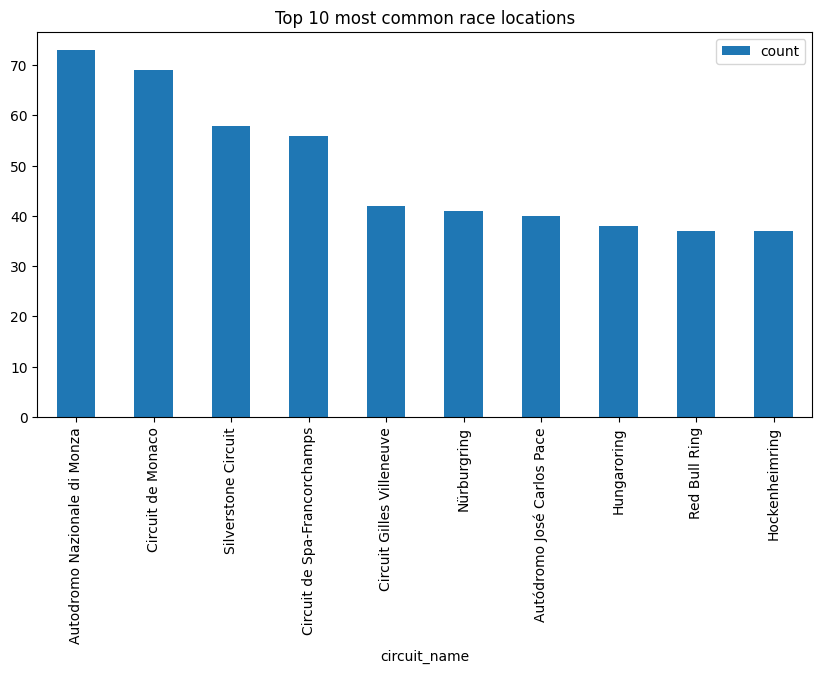

In [ ]:
def analyze_races(df_races, df_circuits, top_N=10):
    # Identify the most common locations for races
    race_counts = df_races['circuitId'].value_counts()
    race_counts = race_counts.reset_index().merge(df_circuits[['circuitId', 'name']], left_on='index', right_on='circuitId')
    race_counts = race_counts.rename(columns={'circuitId_x': 'count', 'name': 'circuit_name'}).drop(columns=['circuitId_y', 'index'])

    # Plot the top N most common race locations
    race_counts.nlargest(top_N, 'count').sort_values(by='count', ascending=False).plot.bar(x='circuit_name', y='count', figsize=(10, 5), title=f'Top {top_N} most common race locations')

    # Visualize race locations on a geographical map
    race_map = folium.Map(zoom_start=2, control_scale=True)
    marker_cluster = MarkerCluster().add_to(race_map)

    for _, row in df_circuits.iterrows():
        folium.Marker(
            location=[row['lat'], row['lng']],
            popup=f"{row['name']} ({row['location']}, {row['country']})"
        ).add_to(marker_cluster)

    return race_map

race_map = analyze_races(df_races, df_circuits, top_N=10)
race_map.save("/content/drive/MyDrive/HW1/race_map.html")



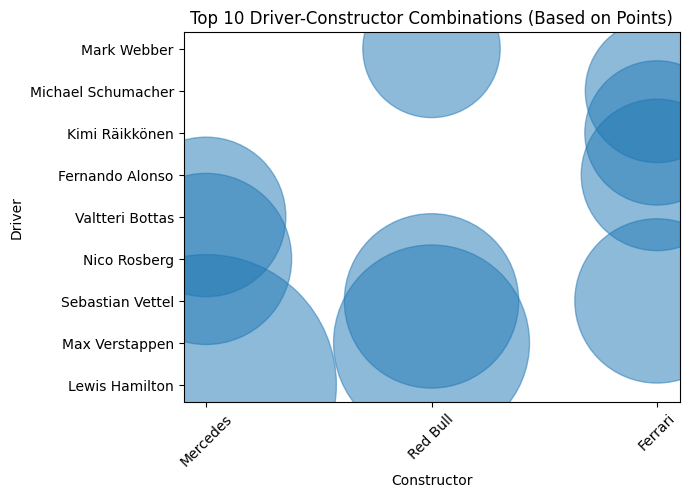

In [ ]:
def analyze_driver_constructor_performance(data_frames, top_N=10):
    # Merge the dataframes with suffixes to differentiate columns
    merged_df = pd.merge(data_frames["df_results"], data_frames["df_drivers"], on="driverId", suffixes=("", "_driver"))
    merged_df = pd.merge(merged_df, data_frames["df_constructors"], on="constructorId", suffixes=("", "_constructor"))

    # Group by driver and constructor combination
    group_df = merged_df.groupby(["driverId", "constructorId", "forename", "surname", "name"])["points"].sum().reset_index()

    # Sort by points and take top_N rows
    group_df = group_df.sort_values(by="points", ascending=False).head(top_N)

    # Create a scatter plot of driver-constructor combinations and their total points
    fig, ax = plt.subplots()
    ax.scatter(group_df["name"], group_df["forename"] + " " + group_df["surname"], s=group_df["points"] * 10, alpha=0.5)
    ax.set_xlabel("Constructor")
    ax.set_ylabel("Driver")
    ax.set_title(f"Top {top_N} Driver-Constructor Combinations (Based on Points)")
    plt.xticks(rotation=45)

    # Save the plot as a temporary PNG file and a PDF file
    temp_png = "temp_plot.png"
    output_pdf = "/content/drive/MyDrive/HW1/driver_constructor_performance.pdf"
    plt.savefig(temp_png, dpi=300, bbox_inches='tight')
    plt.savefig(output_pdf, dpi=300, bbox_inches='tight')

    plt.show()


# Assuming you have loaded the dataframes using the load_and_extract_csv_files function
data_frames = load_and_extract_csv_files("f1db_csv.zip")

# Call the function with the data_frames dictionary and the desired top_N value
analyze_driver_constructor_performance(data_frames, top_N=10)


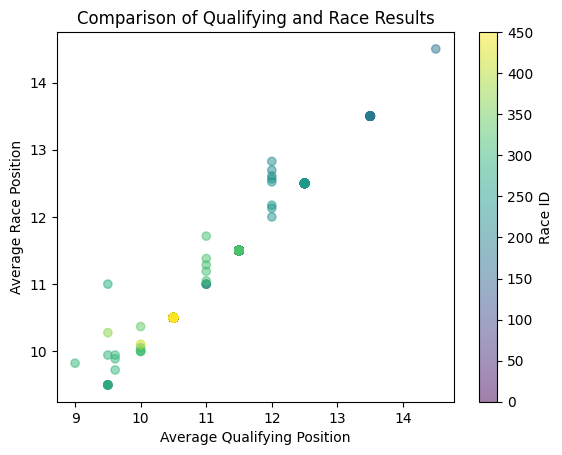

In [ ]:
def compare_qualifying_race_results(data_frames):
    # Merge the dataframes
    merged_df = pd.merge(data_frames["df_qualifying"], data_frames["df_results"], on=["raceId", "driverId", "constructorId"], suffixes=("_quali", "_result"))
    merged_df = pd.merge(merged_df, data_frames["df_races"], on="raceId", suffixes=("", "_race"))

    # Group by raceId and calculate average qualifying and race positions
    group_df = merged_df.groupby(["raceId", "name"])[["position_quali", "positionOrder"]].mean().reset_index()

    # Create a scatter plot of average qualifying and race positions
    fig, ax = plt.subplots()
    scatter = ax.scatter(group_df["position_quali"], group_df["positionOrder"], c=group_df.index, cmap="viridis", alpha=0.5)
    ax.set_xlabel("Average Qualifying Position")
    ax.set_ylabel("Average Race Position")
    ax.set_title("Comparison of Qualifying and Race Results")
    plt.colorbar(scatter, label="Race ID")

    # Save the plot as a PNG file and a PDF file
    output_png = "/content/drive/MyDrive/HW1/qualifying_race_results_comparison.png"
    output_pdf = "/content/drive/MyDrive/HW1/qualifying_race_results_comparison.pdf"
    plt.savefig(output_png, dpi=300, bbox_inches='tight')
    plt.savefig(output_pdf, dpi=300, bbox_inches='tight')

    plt.show()

# Call the function with the data_frames dictionary
compare_qualifying_race_results(data_frames)


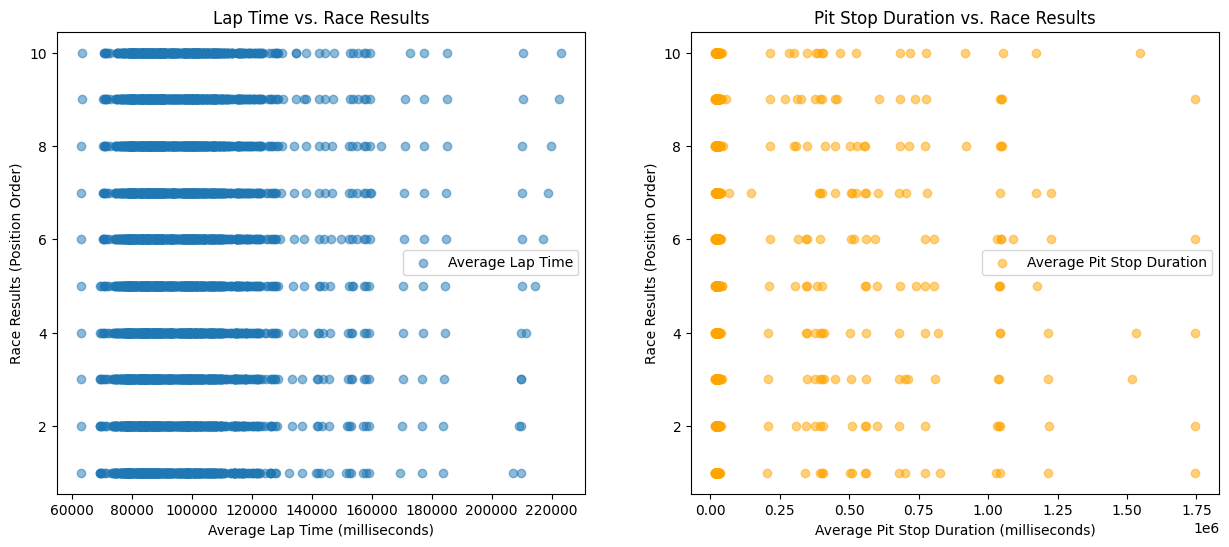

In [ ]:
def analyze_lap_times_pit_stops_results(data_frames, top_N=10):
    lap_times = data_frames["df_lap_times"]
    pit_stops = data_frames["df_pit_stops"]
    results = data_frames["df_results"]

    # Calculate average lap time per driver per race
    lap_times_grouped = lap_times.groupby(["raceId", "driverId"])["milliseconds"].mean().reset_index()
    lap_times_grouped = lap_times_grouped.rename(columns={"milliseconds": "avg_lap_time"})

    # Calculate average pit stop duration per driver per race
    pit_stops_grouped = pit_stops.groupby(["raceId", "driverId"])["milliseconds"].mean().reset_index()
    pit_stops_grouped = pit_stops_grouped.rename(columns={"milliseconds": "avg_pit_stop_duration"})

    # Merge dataframes
    merged_df = pd.merge(results, lap_times_grouped, on=["raceId", "driverId"], how="left")
    merged_df = pd.merge(merged_df, pit_stops_grouped, on=["raceId", "driverId"], how="left")

    # Get top N drivers by race results (positionOrder)
    top_n_drivers = merged_df.sort_values(by="positionOrder").groupby("raceId").head(top_N)

    # Scatter plots and line plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].scatter(top_n_drivers["avg_lap_time"], top_n_drivers["positionOrder"], alpha=0.5, label="Average Lap Time")
    axs[1].scatter(top_n_drivers["avg_pit_stop_duration"], top_n_drivers["positionOrder"], alpha=0.5, color="orange", label="Average Pit Stop Duration")

    axs[0].set(xlabel="Average Lap Time (milliseconds)", ylabel="Race Results (Position Order)", title="Lap Time vs. Race Results")
    axs[1].set(xlabel="Average Pit Stop Duration (milliseconds)", ylabel="Race Results (Position Order)", title="Pit Stop Duration vs. Race Results")

    axs[0].legend()
    axs[1].legend()

    output_png = "/content/drive/MyDrive/HW1/lap_times_pit_stops_results.png"
    output_pdf = "/content/drive/MyDrive/HW1/lap_times_pit_stops_results.pdf"

    plt.savefig(output_png, dpi=300, bbox_inches='tight')
    plt.savefig(output_pdf, dpi=300, bbox_inches='tight')

    plt.show()



# Call the function with the data_frames dictionary and top_N
analyze_lap_times_pit_stops_results(data_frames, top_N=10)


In [18]:
!git remote add origin https://github.com/mbjallow6/Machine-learning-with-python-fhd.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
